In [25]:
import os
from pathlib import Path

import hickle

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns

from ipywidgets import interact, widgets
from tqdm.notebook import tqdm

import smart_settings
from mbrl.environments.tangram import constants

In [2]:
FOLDERS = {
    "house": "house_repair_closeness_200_inner3_control0066_nomaxdist__1",
    "tree": "tree_repair_closeness_200_inner3_control0066_nomaxdist",
    "tree_128": "closeness_100_inner3_128_control0066_nomaxdist_best",
    "tree_x3_256": "closeness_100_inner3_256_control0066_nomaxdist_best_x3",
    "tree_e20_128": "closeness_100_inner3_e20_128_control0066_nomaxdist_best",
    "tree_e20_256": "closeness_100_inner3_e20_256_control0066_nomaxdist_best"
}
FRAMES = 60

In [3]:
def extract_settings(params):
    return (
        params.controller_params.compression,
        # params.controller_params.render_kwargs.invert,
        # params.controller_params.render_kwargs.color,
        # params.controller_params.semantics_baseline,
        params.controller_params.action_sampler_params.opt_iterations,
        params.controller_params.action_sampler_params.init_std,
        params.controller_params.action_sampler_params.elites_size,
        params.controller_params.num_simulated_trajectories,
        params.controller_params.horizon,
        params.env_params.x_size,
        params.env_params.get("r_size", 4),
        params.env_params.x_step,
        params.controller_params.get('compression_precision', params.controller_params.get('precision')),
        # str(params.env_params.get("staging_boundaries", [[0, 0], [1., 1.]])),
        params.env_params.object_persistency,
        # params.controller_params.semantics_model_temperature,
        # params.controller_params.semantics_alpha_target,
        # params.controller_params.semantics_beta_image,
        params.controller_params.cost_along_trajectory,
        params.controller_params.closeness_reward_scale,
        params.controller_params.closeness_reward_threshold,
        params.get("seed", params.env_params.get("seed", None))
    )

results = pd.DataFrame(columns=[
    "shape",
    "rair",
    # "inversion",
    # "color",
    # "baseline",
    "opt_iterations",
    "init_std",
    "elites_size",
    "num_simulated_trajectories",
    "horizon",
    "x_size",
    "r_size",
    "x_step",
    "compression_precision",
    # "staging_boundaries",
    "object_persistency",
    # "temperature",
    # "alpha_target",
    # "beta_image",
    "cost_along_trajectory",
    "closeness_reward_scale",
    "closeness_reward_threshold",
    "seed",
    "completed",
    "sum_closeness_costs",
    "final_closeness_cost"
])

In [4]:
def model_closeness_costs(all_observations, params: dict):
    distance_vector = np.abs(all_observations[:, :-2 if params.env_params.object_persistency else None].reshape(FRAMES, -1, 2) - np.array(params.controller_params.closeness_target) * params.env_params.get("scale", constants.DEFAULT_SCALE))
    if params.controller_params.closeness_reward_threshold > 0:  # Sparse thresholded
        closeness_cost_values = (distance_vector > params.controller_params.closeness_reward_threshold).all(axis=-1).sum(axis=-1)
    else:
        distance = np.linalg.norm(distance_vector, axis=-1)
        if params.controller_params.closeness_reward_threshold < 0:  # Sparse incremental
            closeness_cost_values = np.where(distance > -params.controller_params.closeness_reward_threshold, 1, distance / -params.controller_params.closeness_reward_threshold).sum(axis=-1)
        else:  # Dense
            closeness_cost_values = distance.sum(axis=-1)
    return closeness_cost_values  # .sum()  # / max(closeness_cost_values)

In [5]:
closeness_costs = dict()
for id, folder in FOLDERS.items():
    for job in tqdm(os.listdir(folder)):
        params = smart_settings.load(os.path.join(folder, job, "settings.json"), make_immutable=False)
        try:
            buffers = hickle.load(os.path.join(folder, job, "checkpoints_latest/rollouts"))
        except FileNotFoundError:
            completed = False
            closeness_costs[f'{id}_{job}'] = None
        else:
            completed = True
            for i in range(len(buffers)):
                closeness_costs[(index := f'{id}_{job}' + (f'_{i}' if i else ''))] = model_closeness_costs(buffers[i]["next_observations"][:FRAMES], params)  # np.r_[buffer[0]["observations"][:1], buffer[0]["observations"]]
                results.loc[index] = [id.split('_')[0], *extract_settings(params), completed, closeness_costs[index].sum() if completed else np.nan, closeness_costs[index][-1] if completed else np.nan]

  0%|          | 0/2010 [00:00<?, ?it/s]

  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/1920 [00:00<?, ?it/s]

  0%|          | 0/1920 [00:00<?, ?it/s]

  0%|          | 0/1920 [00:00<?, ?it/s]

  0%|          | 0/1920 [00:00<?, ?it/s]

In [6]:
compute = lambda f, closeness_costs=closeness_costs, alt=np.nan: pd.Series(map(lambda x: (alt if x is None else f(x)), closeness_costs.values()), closeness_costs.keys())

In [7]:
results['sum_closeness_costs_normalized'] = compute(lambda x: x.sum() / x.max())
results['sum_closeness_costs_centered'] = compute(lambda x: (x - x.max()).sum())
results['reached'] = compute(lambda x: (x < 1).any(), alt=False)

In [8]:
results.sort_values("sum_closeness_costs", inplace=True)
results["complexity"] = results["horizon"] * results["num_simulated_trajectories"]

``` sh
gram tree_repair_closeness_200_inner3_control0066_nomaxdist/$1 --save-path results/tangram_videos/new/tree_repair_closeness_200_inner3_control0066_nomaxdist/$1
```

In [9]:
# Best performing
results.iloc[0]

shape                             closeness
rair                                   True
opt_iterations                            3
init_std                                2.0
elites_size                              20
num_simulated_trajectories              256
horizon                                  24
x_size                                    1
r_size                                    4
x_step                                    5
compression_precision                    28
object_persistency                        0
cost_along_trajectory                  best
closeness_reward_scale                  5.0
closeness_reward_threshold            0.051
seed                                      5
completed                              True
sum_closeness_costs                    35.0
final_closeness_cost                    0.0
sum_closeness_costs_normalized     2.916667
sum_closeness_costs_centered         -685.0
reached                                True
complexity                      

In [10]:
# Best performing with minimum complexity
# results[results["complexity"] == results["complexity"].min()].iloc[0]

In [11]:
# Only for sparse incremental rewards
results[(results["closeness_reward_threshold"] != 0)].iloc[0]  #  & (results["complexity"] == results["complexity"].min())

shape                             closeness
rair                                   True
opt_iterations                            3
init_std                                2.0
elites_size                              20
num_simulated_trajectories              256
horizon                                  24
x_size                                    1
r_size                                    4
x_step                                    5
compression_precision                    28
object_persistency                        0
cost_along_trajectory                  best
closeness_reward_scale                  5.0
closeness_reward_threshold            0.051
seed                                      5
completed                              True
sum_closeness_costs                    35.0
final_closeness_cost                    0.0
sum_closeness_costs_normalized     2.916667
sum_closeness_costs_centered         -685.0
reached                                True
complexity                      

In [12]:
# plt.scatter(range(len(results)), results["sum_closeness_costs"], s=0.05)  # c=results["cost_along_trajectory"].replace({"best": "r", "sum": "b"})

In [13]:
# results["XIC"] = np.log(results["sum_closeness_costs"]) + results["complexity"]
# results.sort_values("XIC")

In [14]:
results

,shape,rair,opt_iterations,init_std,elites_size,num_simulated_trajectories,horizon,x_size,r_size,x_step,...,closeness_reward_scale,closeness_reward_threshold,seed,completed,sum_closeness_costs,final_closeness_cost,sum_closeness_costs_normalized,sum_closeness_costs_centered,reached,complexity
tree_e20_256_1896,closeness,True,3,2.0,20,256,24,1,4,5,...,5.0,0.051,5,True,35.000000,0.000000,2.916667,-685.000000,True,6144
tree_e20_256_712,closeness,True,3,0.6,20,256,16,1,4,5,...,0.5,0.051,5,True,39.000000,0.000000,2.600000,-861.000000,True,4096
tree_1119,tree,False,3,0.6,10,256,15,28,4,5,...,100.0,0.000,5,True,39.954337,0.347001,9.909289,-201.966178,True,3840
tree_e20_128_996,closeness,True,3,0.2,20,128,24,1,4,3,...,1.0,0.051,5,True,41.000000,0.000000,3.153846,-739.000000,True,3072
tree_x3_256_1768,closeness,True,3,1.0,10,256,24,1,4,5,...,5.0,0.051,5,True,42.000000,0.000000,3.000000,-798.000000,True,6144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tree_e20_128_424,closeness,True,3,0.6,20,128,24,1,4,5,...,0.2,0.051,5,True,1244.000000,22.000000,54.086957,-136.000000,False,3072
tree_e20_256_333,closeness,True,3,0.2,20,256,16,1,4,7,...,0.2,0.051,5,True,1257.000000,22.000000,57.136364,-63.000000,False,4096
tree_e20_128_420,closeness,True,3,0.6,20,128,24,1,4,3,...,0.2,0.051,5,True,1326.000000,23.000000,57.652174,-54.000000,False,3072
tree_x3_256_520_2,closeness,True,3,1.5,10,256,16,1,4,5,...,0.2,0.051,5,True,1327.000000,23.000000,57.695652,-53.000000,False,4096


In [37]:
mask = results['completed'] & (results['shape'] == 'closeness') & (results['x_size'] == 1) & (results['object_persistency'] != 0)
print(mask.sum())
interact(lambda x, y="sum_closeness_costs": sns.boxplot(x=x, y=y, data=results[mask]), x=results.columns, y=results.columns)

interactive(children=(Dropdown(description='x', options=('shape', 'rair', 'opt_iterations', 'init_std', 'elite…

<function __main__.<lambda>(x, y='sum_closeness_costs')>

In [16]:
results.loc['house_495']

shape                                  house
rair                                   False
opt_iterations                             3
init_std                                 0.6
elites_size                               10
num_simulated_trajectories               256
horizon                                   21
x_size                                     1
r_size                                     4
x_step                                     3
compression_precision                      1
object_persistency                         0
cost_along_trajectory                      1
closeness_reward_scale                 100.0
closeness_reward_threshold            -0.051
seed                                       5
completed                               True
sum_closeness_costs               932.789638
final_closeness_cost               15.011985
sum_closeness_costs_normalized     50.411381
sum_closeness_costs_centered     -177.423513
reached                                False
complexity

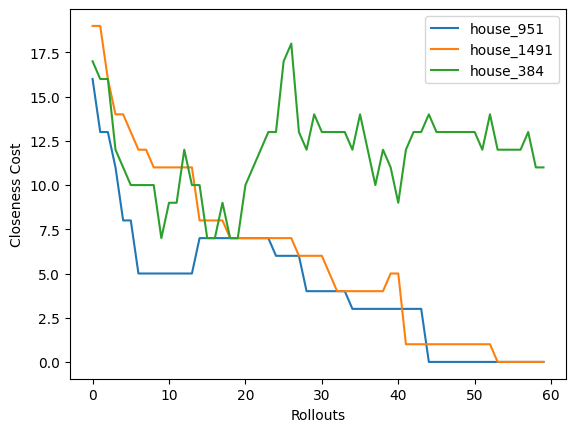

In [17]:
for key in ['house_951', 'house_1491', 'house_384']:  # ['house_313', 'house_168', 'house_222']
    plt.plot(closeness_costs[key], label=key)
plt.xlabel("Rollouts")
plt.ylabel("Closeness Cost")
plt.legend();

In [18]:
# tree_576
# house_951